In [21]:
%reload_ext autoreload
%autoreload 2

from skills_ml.ontologies.onet import majorgroupname

import os
import json
import statistics
import operator
from collections import Counter, defaultdict
from functools import reduce, partial
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="darkgrid", font_scale=2)
%matplotlib inline

In [82]:
# some plotting functions
def plot_major_group_distribution(job_postings):
    c = Counter()
    for job in job_postings:
        c.update([job['onet_soc_code'][:2]])
    s = pd.Series(c).sort_index()
    s.index = s.index.map(majorgroupname)
    ax = s.plot.bar(figsize=(20,10),rot=90)
    ax.set_xlabel('soc_major_group')
    ax.set_ylabel('number of job posting')
    ax.set_title(f"total number: {s.sum()}")
    return s



def algorithm_name(emb):
    if emb.model_type == 'word2vec' or emb.model_type == 'fasttext':
        if getattr(emb, 'sg', None) == 1:
            return 'Skip-Gram'
        else:
            return 'Continuous Bag of Words'
        
    elif emb.model_type == 'doc2vec':
        if getattr(emb, 'dm', None) == 1:
            return 'Distributed Memory'
        else:
            return 'Distributed Bag of Words'


def evaluate(embeddings, vectorization, metric):
    result = defaultdict(dict)
    for emb in embeddings:
        c = metric.eval(vectorization(emb))
        name = emb.model_name.split('.')[0]
        result[name]['mean'] = statistics.mean(list(c.values()))
        result[name]['variance'] = statistics.variance(list(c.values()))
        result[name]['std'] = statistics.stdev(list(c.values()))
        result[name]['max'] = max(c.items(), key=operator.itemgetter(1))[1]
        result[name]['max_cluster'] = max(c.items(), key=operator.itemgetter(1))[0]
        result[name]['min'] = min(c.items(), key=operator.itemgetter(1))[1]
        result[name]['min_cluster'] = min(c.items(), key=operator.itemgetter(1))[0]
        result[name]['type'] = emb.model_type
        result[name]['algorithm'] = algorithm_name(emb)
        result[name]['window'] = emb.window
    
    return pd.DataFrame(result)


def itershuffle(iterable, bufsize=1000):
    """Shuffle an iterator. This works by holding `bufsize` items back
    and yielding them sometime later. This is NOT 100% random, proved or anything."""
    iterable = iter(iterable)
    buf = []
    try:
        while True:
            for i in range(random.randint(1, bufsize-len(buf))):
                buf.append(next(iterable))
            random.shuffle(buf)
            for i in range(random.randint(1, bufsize)):
                if buf:
                    yield buf.pop()
                else:
                    break
    except StopIteration:
        random.shuffle(buf)
        while buf:
            yield buf.pop()
        raise StopIteration

# Skills-ML Tour

Skills-ML is an open source software library for applying NLP and ML to labor market data. It allows the user to perform tasks like skill extraction and occupation classification to collections of documents such as job postings, profiles, and course descriptions.

## Competency

A competency is any expertise or talent that is useful for a job. Developed capacities (e.g. active listening), proficiency with tools or technology (e.g. lancets, Microsoft Word), innate abilities (e.g. originality), and academic knowledge (e.g. medicine) are all considered competencies.

In [156]:
from skills_ml.ontologies import Competency

dinosaur_riding = Competency(
    identifier='dino_riding',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

### Competency Relationships

Competencies are often related to each other. Defining parent-child relationships is a standard building block of existing competency frameworks like ONET and ESCO. A parent-child relationship generally implies that the child is a "type of" the parent.

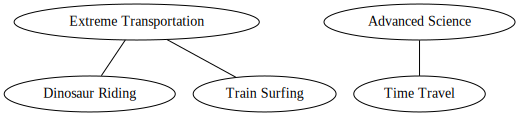

In [157]:
from skills_ml.ontologies import Competency
from skills_ml.ontologies.viz import display_nodes

dinosaur_riding = Competency(
    identifier='12345',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

train_surfing = Competency(
    identifier='12346',
    name='Train Surfing',
    description='Standing on the train while it goes'
)

time_travel = Competency(
    identifier='23456',
    name='Time Travel',
    description='Traveling Through Time'
)

advanced_science = Competency(
    identifier='2345',
    name='Advanced Science',
)

extreme_transportation = Competency(
    identifier='123',
    name='Extreme Transportation',
    description='Comically dangerous forms of transportation'
)
time_travel.add_parent(advanced_science)
dinosaur_riding.add_parent(extreme_transportation)
train_surfing.add_parent(extreme_transportation)
display_nodes([dinosaur_riding, train_surfing, extreme_transportation, time_travel, advanced_science])

## Occupation

An occupation is a job or profession that a person can hold. Similar to competencies, these are also often defined hierarchically.


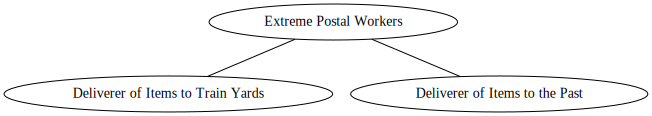

In [135]:
from skills_ml.ontologies import Occupation

extreme_postal_workers = Occupation(identifier='999', name='Extreme Postal Workers')
dino_postal_worker = Occupation(identifier='9998', name='Deliverer of Items to the Past')
train_yard_postal_worker = Occupation(identifier='9999', name='Deliverer of Items to Train Yards')
dino_postal_worker.add_parent(extreme_postal_workers)
train_yard_postal_worker.add_parent(extreme_postal_workers)

display_nodes([extreme_postal_workers, dino_postal_worker, train_yard_postal_worker])

# CompetencyOntology

A CompetencyOntology is a model of the labor market, or some subset thereof, consisting of a collection of competencies, a collection of occupations, and all of the relationships between them.

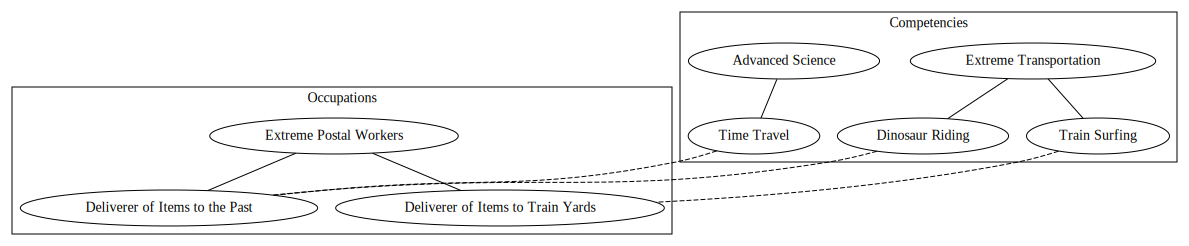

In [136]:
from skills_ml.ontologies import CompetencyOntology
from skills_ml.ontologies.viz import display_ontology

ontology = CompetencyOntology()
ontology.add_competency(dinosaur_riding)
ontology.add_competency(train_surfing)
ontology.add_competency(extreme_transportation)
ontology.add_competency(time_travel)
ontology.add_competency(advanced_science)

ontology.add_occupation(dino_postal_worker)
ontology.add_occupation(train_yard_postal_worker)
ontology.add_occupation(extreme_postal_workers)

ontology.add_edge(occupation=dino_postal_worker, competency=dinosaur_riding)
ontology.add_edge(occupation=dino_postal_worker, competency=time_travel)
ontology.add_edge(occupation=train_yard_postal_worker, competency=train_surfing)

display_ontology(ontology)

## Prebuilt Ontologies

To move on we'll want to level up to a full ontology. The example we'll use is O\*NET, built from survey data and maintained by the US Department of Labor. A CompetencyOntology subclass that downloads the source files from the O\*NET web site is included in Skills-ML.

In [137]:
from skills_ml.ontologies.onet import Onet
onet = Onet()
onet.print_summary_stats()

INFO:root:Manual build specified. Building O*NET CompetencyOntology via direct querying from O*NET site, or local cache.
INFO:root:Processing Content Model Reference
INFO:root:Processing occupation data
INFO:root:Processing Knowledge, Skills, Abilities
INFO:root:Processing tools and technology


Ontology summary statistics for onet
Num competencies: 32030
Num occupations: 1133
Num competency-occupation edges: 107305
Median occupations per competency: 1
Median competencies per occupation: 89
Mean occupations per competency: 3.350245090386837
Mean competencies per occupation: 94.70873786407768


In [138]:
list(onet.competencies)[0:5]

[Competency(identifier=23101512-Multiple blade sawing machines, name=Multiple blade sawing machines, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=27112709-Beam saws, name=Beam saws, categories=['Tools', 'O*NET T2'], {}),
 Competency(identifier=43232605-PowerWorld software, name=PowerWorld software, categories=['Technology', 'O*NET T2'], {}),
 Competency(identifier=43232605-ANSYS FLUENT, name=ANSYS FLUENT, categories=['Technology', 'O*NET T2'], {}),
 Competency(identifier=41114303, name=Open stream water level recorders, categories=['Tools', 'UNSPSC Commodity'], {})]

### Filtering

~34000 competencies and ~1100 occupations is a lot. Let's explore the filtering functionality of the CompetencyOntology to zoom in on a more specific slice.

`filter_by` filters using edges: the filtering function it expects takes in an edge (between a Competency and Occupation) and returns whether or not it should be in the result. The result takes the form of a new CompetencyOntology, so you can interact with it in the same way as you would the source ontology. 

In [139]:
nurse_practitioners = onet.filter_by(lambda edge: 'Nurse Practitioners' in edge.occupation.name)
nurse_practitioners.competencies

{Competency(identifier=1.A.1.a.1, name=Oral Comprehension, categories=['Abilities'], {'competencyText': 'The ability to listen to and understand information and ideas presented through spoken words and sentences.'}),
 Competency(identifier=1.A.1.a.2, name=Written Comprehension, categories=['Abilities'], {'competencyText': 'The ability to read and understand information and ideas presented in writing.'}),
 Competency(identifier=1.A.1.a.3, name=Oral Expression, categories=['Abilities'], {'competencyText': 'The ability to communicate information and ideas in speaking so others will understand.'}),
 Competency(identifier=1.A.1.a.4, name=Written Expression, categories=['Abilities'], {'competencyText': 'The ability to communicate information and ideas in writing so others will understand.'}),
 Competency(identifier=1.A.1.b.1, name=Fluency of Ideas, categories=['Abilities'], {'competencyText': 'The ability to come up with a number of ideas about a topic (the number of ideas is important, not 

That's a big list of competencies. Each competency has a list of categories, so let's get all of the different possible categories

In [140]:
set(cat for competency in nurse_practitioners.competencies for cat in competency.categories)

{'Abilities', 'Knowledge', 'O*NET T2', 'Skills', 'Technology', 'Tools'}

So we can ask questions like: what type of Knowledge do nurse practitioners need?

In [141]:
[competency for competency in nurse_practitioners.competencies if 'Knowledge' in competency.categories]

[Competency(identifier=2.C.5.b, name=Therapy and Counseling, categories=['Knowledge'], {'competencyText': 'Knowledge of principles, methods, and procedures for diagnosis, treatment, and rehabilitation of physical and mental dysfunctions, and for career counseling and guidance.'}),
 Competency(identifier=2.C.8.a, name=Public Safety and Security, categories=['Knowledge'], {'competencyText': 'Knowledge of relevant equipment, policies, procedures, and strategies to promote effective local, state, or national security operations for the protection of people, data, property, and institutions.'}),
 Competency(identifier=2.C.7.a, name=English Language, categories=['Knowledge'], {'competencyText': 'Knowledge of the structure and content of the English language including the meaning and spelling of words, rules of composition, and grammar.'}),
 Competency(identifier=2.C.4.a, name=Mathematics, categories=['Knowledge'], {'competencyText': 'Knowledge of arithmetic, algebra, geometry, calculus, stat

There are many other questions we can ask of just an ontology, but the real value will come from combining the knowledge contained in the ontology with larger unstructured datasets. In this next section we will explore how Skills-ML helps the user deal with such datasets as job postings, profiles, or course descriptions.

# Spirit of Skills-ML

- **Dataflow Programming**: `Skills-ML`'s design philosophy builds on dataflow programming or so called data streaming to process very large datasets (larger than RAM; potentially infinite). 
- **One-pass algorithm**: Data points are processed one at a time.
- **Lazy evaluation**: an evaluation strategy which delays the evaluation of an expression until its value is needed. In `Skills-ML`, most of the classes and functions here incorporates the concept of `Iterable` or `Generator`. We build the expression first and evaluate later. 

# Creating Dataset

Before we do anything with the context, we need dataset. `Skills-ML` makes use of schema.org’s JobPosting standard. As it has been in use for a long time, some open sources are already using this standard, which is easy to import. Other job posting data sources are converted into the schema.org Schema and all work on job postings is done using this standard schema. 

In `Skills-ML`, `job_postings` module has all the functionalities to create the data we need for later usage. 

## Common Schema

We have an useful function to help create the data generator from s3. 

- `JobPostingCollectionFromS3`: Stream job posting from s3.
- `JobPostingCollectionSample`: Stream a finite number of job postings stored within the library.

However, we are not restrcted to just JobPosting data. One can easily create whatever data generator such as `ProfileGenerator` or `CourseGenerator`. 

For example, we want to use the Vrigina Dataset which is an open data set of job postings. We just have to create a job posting generator with some transformation. 

In [158]:
from skills_ml.job_postings.raw.virginia import VirginiaTransformer
from urllib.request import urlopen

va_url = "http://opendata.cs.vt.edu/dataset/ab0abac3-2293-4c9d-8d80-22d450254389/resource/074f7e44-9275-4bba-874e-4795e8f6830c/download/openjobs-jobpostings.may-2016.json"

class VAJobposting(object):
    def __init__(self, uri):
        self.uri = uri
    
    def __iter__(self):
        request = urlopen(self.uri)
        for line in request.readlines():
            raw = json.loads(line)
            yield VirginiaTransformer(partner_id="va")._transform(raw)
            

jobpostings_va = VAJobposting(va_url)

In [159]:
print(len(list(jobpostings_va)))

40098


## Filtering

To create a good dataset, we might want to have some criteria for choosing the proper job posting based on the task we want to perform, like job postings that have the label information, job postings that belong to certain occupation, or job postings that have rich enough information in the description field.

- `JobPostingFilterer`: Filter common schema job postings through a number of filtering functions.

This function also follows lazy evaluation strategy.

In [6]:
from skills_ml.job_postings.filtering import JobPostingFilterer

def is_tech_jobs(job):
    if job['onet_soc_code'][:2] in ['15', '17', '19']:
        return True
    else:
        return False
    
tech_jobs = JobPostingFilterer(
    job_posting_generator=VAJobposting(va_url), 
    filter_funcs=[is_tech_jobs]
)

Computer and Mathematical             5065
Architecture and Engineering          1937
Life, Physical, and Social Science     192
dtype: int64

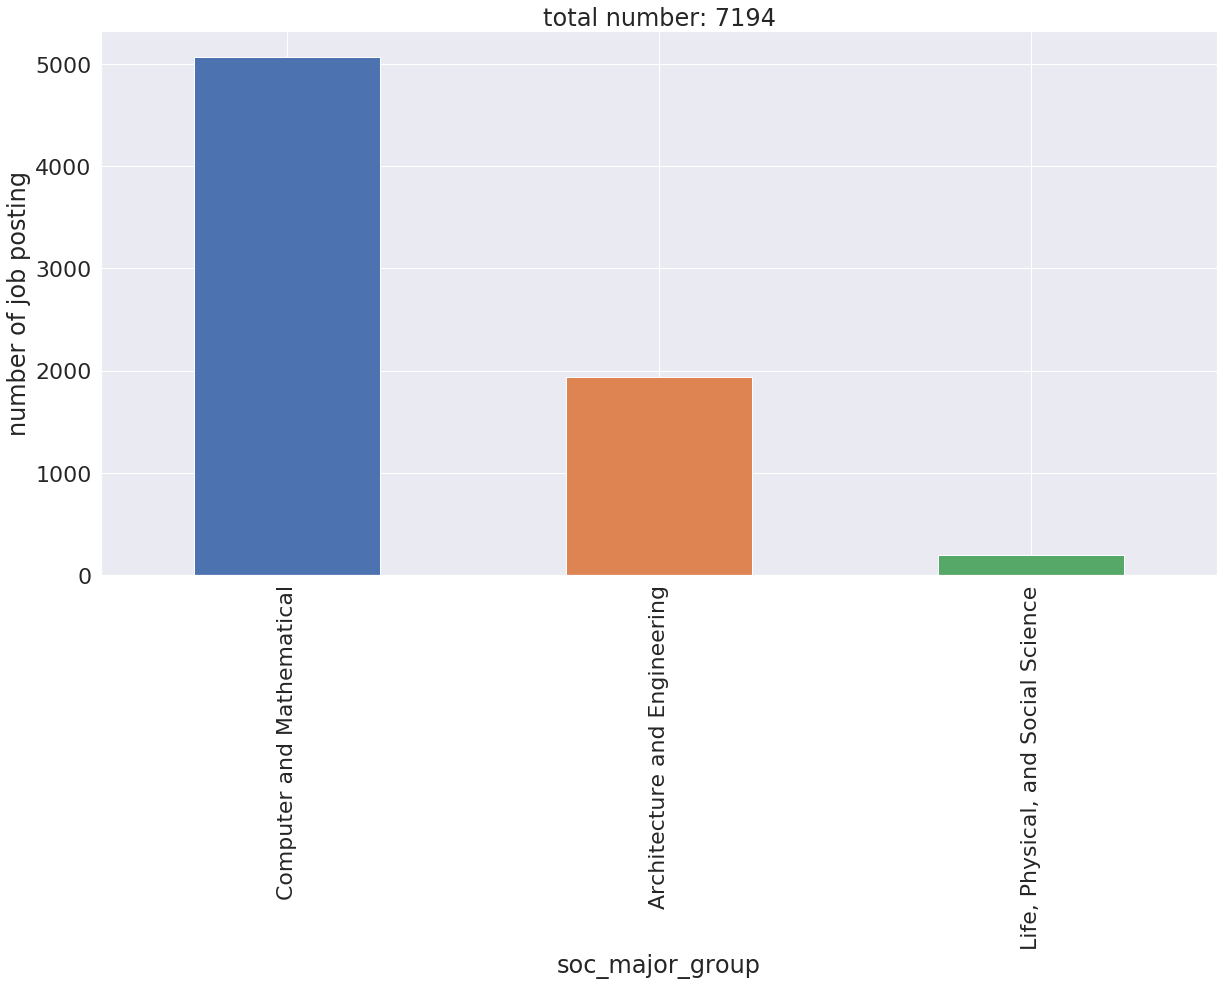

In [7]:
plot_major_group_distribution(tech_jobs)

What if we want to make sure that all the job postings have ONet SOC Code and it's not unknown(first 2 digit 99)? We can define filter functions like these which can be either generic function or lambda function.

In [8]:
def filter_onet_soc_code(job):
    if job['onet_soc_code'] and job['onet_soc_code'][:2] != '99':
        return True
    else:
        return False

has_soc = lambda x: x['onet_soc_code']
not_unknown_soc = lambda x: x['onet_soc_code'][:2] != '99'

In [9]:
jobpostings_filtered = JobPostingFilterer(
    job_posting_generator=VAJobposting(va_url), 
    filter_funcs=[has_soc, not_unknown_soc]
)

Management                                        6506
Business and Financial Operations                 3867
Computer and Mathematical                         5065
Architecture and Engineering                      1937
Life, Physical, and Social Science                 192
Community and Social Service                       282
Legal                                               94
Education, Training, and Library                   679
Arts, Design, Entertainment, Sports, and Media     598
Healthcare Practitioners and Technical            3447
Healthcare Support                                 494
Protective Service                                 484
Food Preparation and Serving Related               792
Building and Grounds Cleaning and Maintenance      189
Personal Care and Service                           97
Sales and Related                                 1415
Office and Administrative Support                 2580
Construction and Extraction                        196
Installati

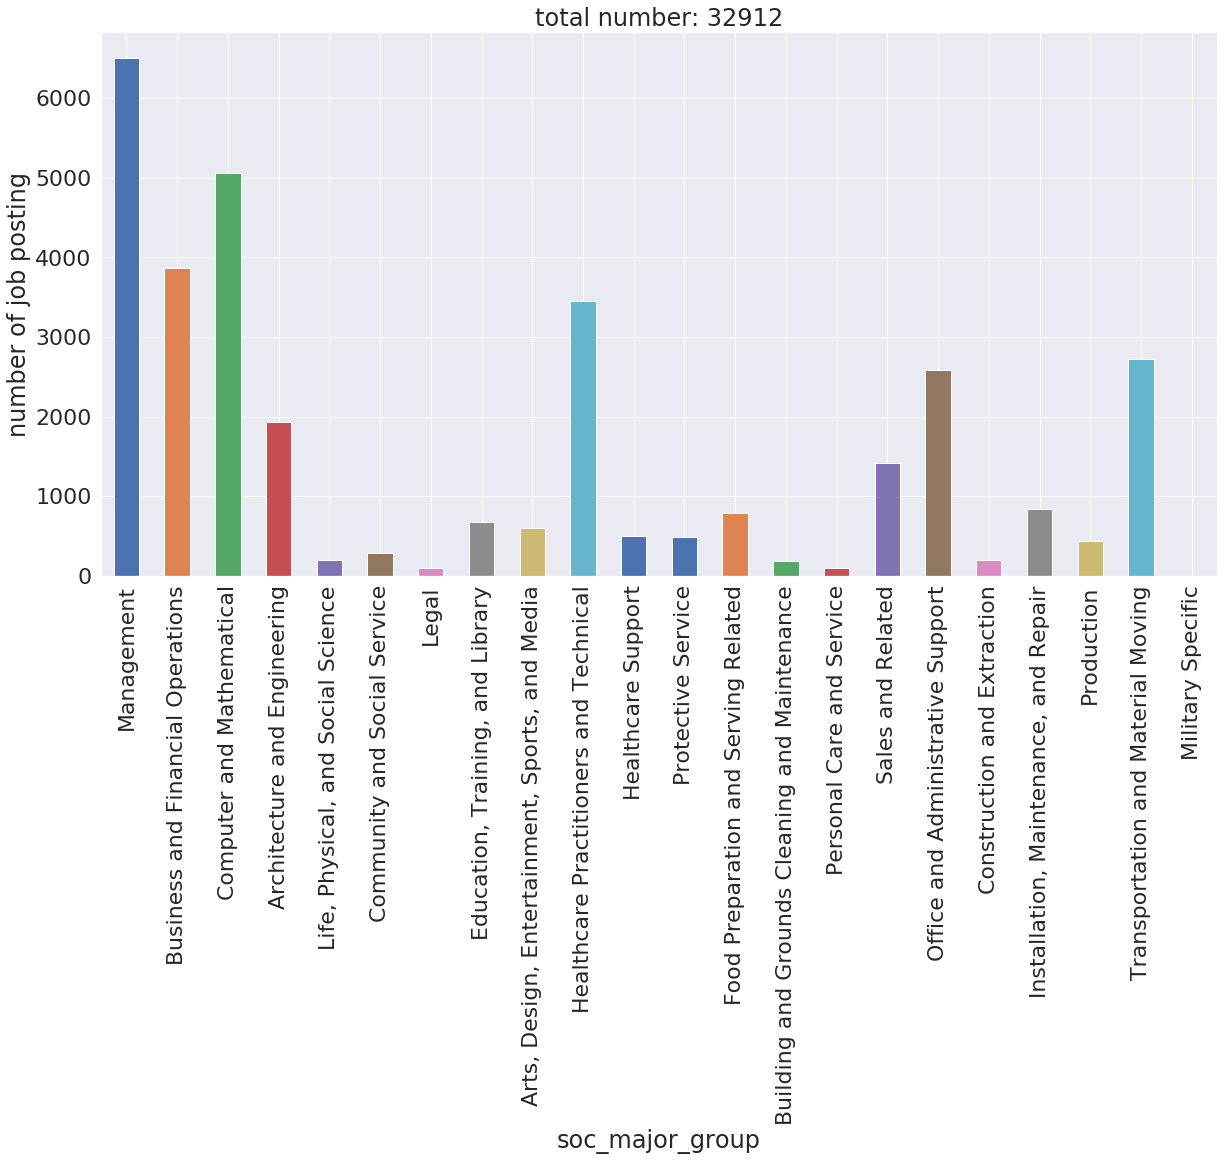

In [10]:
plot_major_group_distribution(jobpostings_filtered)

## Random Sampling

Even though we have a lot of data, most of time we don't need all of them to do the analysis. Or we can't even fit all the data into memory to do the analysis. What we need more importantly is a suitable sampled dataset.

- `JobSampler`: Sample job posting by (weighted) reservoir sampling. 

### Random Sampling from Streaming Data - Reservoir Sampling

- "Say you have a stream of items of large and unknown length that we can only iterate over once."
- It's memeory efficient and just one iteration
- There is a great overview of reservoir sampling in https://gregable.com/2007/10/reservoir-sampling.html. 

Let's say the original job postings dataset are too much for my Mac Yosemite to do any analysis and I want only 1000 job postings but still preserve the statistical characteristics of the original dataset. 

In [144]:
from skills_ml.job_postings.sample import JobSampler

sampler = JobSampler(
    job_posting_generator=jobpostings_filtered, 
    k=1000,
)

Management                                        189
Business and Financial Operations                 114
Computer and Mathematical                         149
Architecture and Engineering                       57
Life, Physical, and Social Science                  5
Community and Social Service                        7
Legal                                               2
Education, Training, and Library                   21
Arts, Design, Entertainment, Sports, and Media     24
Healthcare Practitioners and Technical            108
Healthcare Support                                 14
Protective Service                                  9
Food Preparation and Serving Related               21
Building and Grounds Cleaning and Maintenance       7
Personal Care and Service                           5
Sales and Related                                  50
Office and Administrative Support                  77
Construction and Extraction                         8
Installation, Maintenance, a

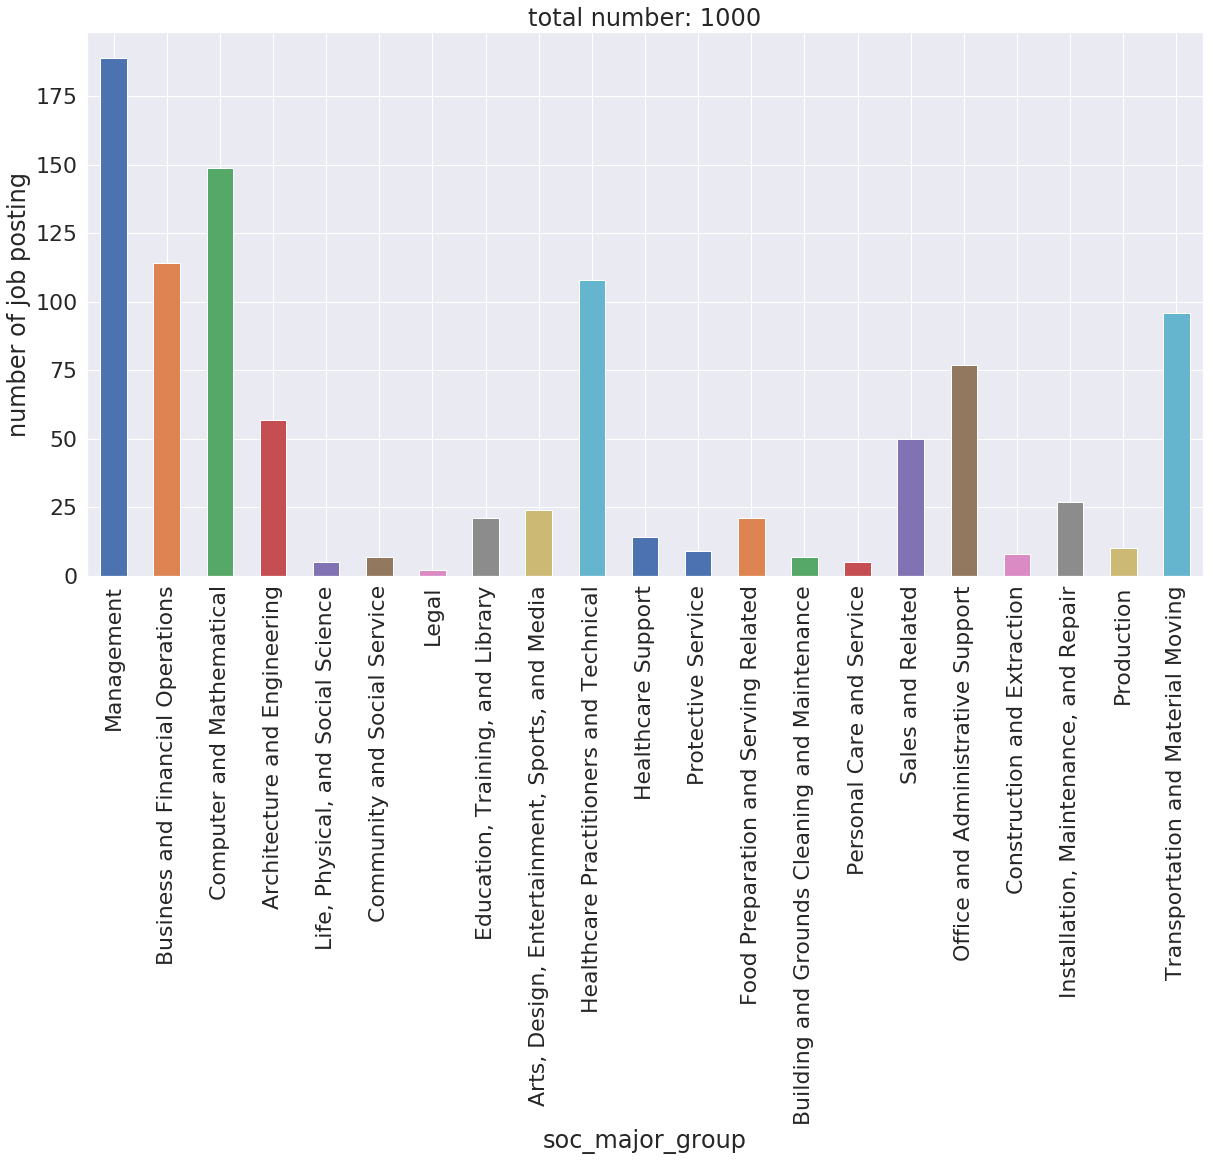

In [145]:
plot_major_group_distribution(sampler)

Something wrong happened! We are missing `Military Occupations`! Because military job postings are extremely rare in the original dataset, simple ramdom sampling might result in lack of classes.

## Weighted Reservoir Sampling

- How would you sample from a weighted distribution where each element has a given weight associated with it in the stream?

- For certain task, we need some curated sample. For example, if we want to build a occupation classifier, we want similar amounts of job posting for each occupation. 

Now we want to have a more uniform distributed sample across all major groups. 
Here we need to provide a weight dictionary in the `JobSampler`

In [13]:
c = Counter()
for job in jobpostings_filtered:
    c.update([job['onet_soc_code'][:2]])
weights = dict()
for key, value in c.items():
    weights[key] = max(c.values()) / value

In [14]:
weights

{'11': 1.0,
 '15': 1.2845014807502468,
 '17': 3.3588022715539494,
 '29': 1.8874383521903104,
 '41': 4.597879858657244,
 '43': 2.521705426356589,
 '13': 1.6824411688647531,
 '49': 7.819711538461538,
 '33': 13.442148760330578,
 '27': 10.879598662207357,
 '47': 33.19387755102041,
 '51': 14.71945701357466,
 '35': 8.214646464646465,
 '25': 9.581737849779087,
 '31': 13.17004048582996,
 '19': 33.885416666666664,
 '21': 23.070921985815602,
 '37': 34.423280423280424,
 '53': 2.3901542983100663,
 '39': 67.0721649484536,
 '23': 69.2127659574468,
 '55': 3253.0}

In [142]:
sampler = JobSampler(job_posting_generator=jobpostings_filtered, k=1000, major_group=True, weights=weights)

Management                                        55
Business and Financial Operations                 46
Computer and Mathematical                         50
Architecture and Engineering                      52
Life, Physical, and Social Science                35
Community and Social Service                      41
Legal                                             48
Education, Training, and Library                  54
Arts, Design, Entertainment, Sports, and Media    64
Healthcare Practitioners and Technical            46
Healthcare Support                                43
Protective Service                                49
Food Preparation and Serving Related              58
Building and Grounds Cleaning and Maintenance     41
Personal Care and Service                         46
Sales and Related                                 46
Office and Administrative Support                 52
Construction and Extraction                       45
Installation, Maintenance, and Repair         

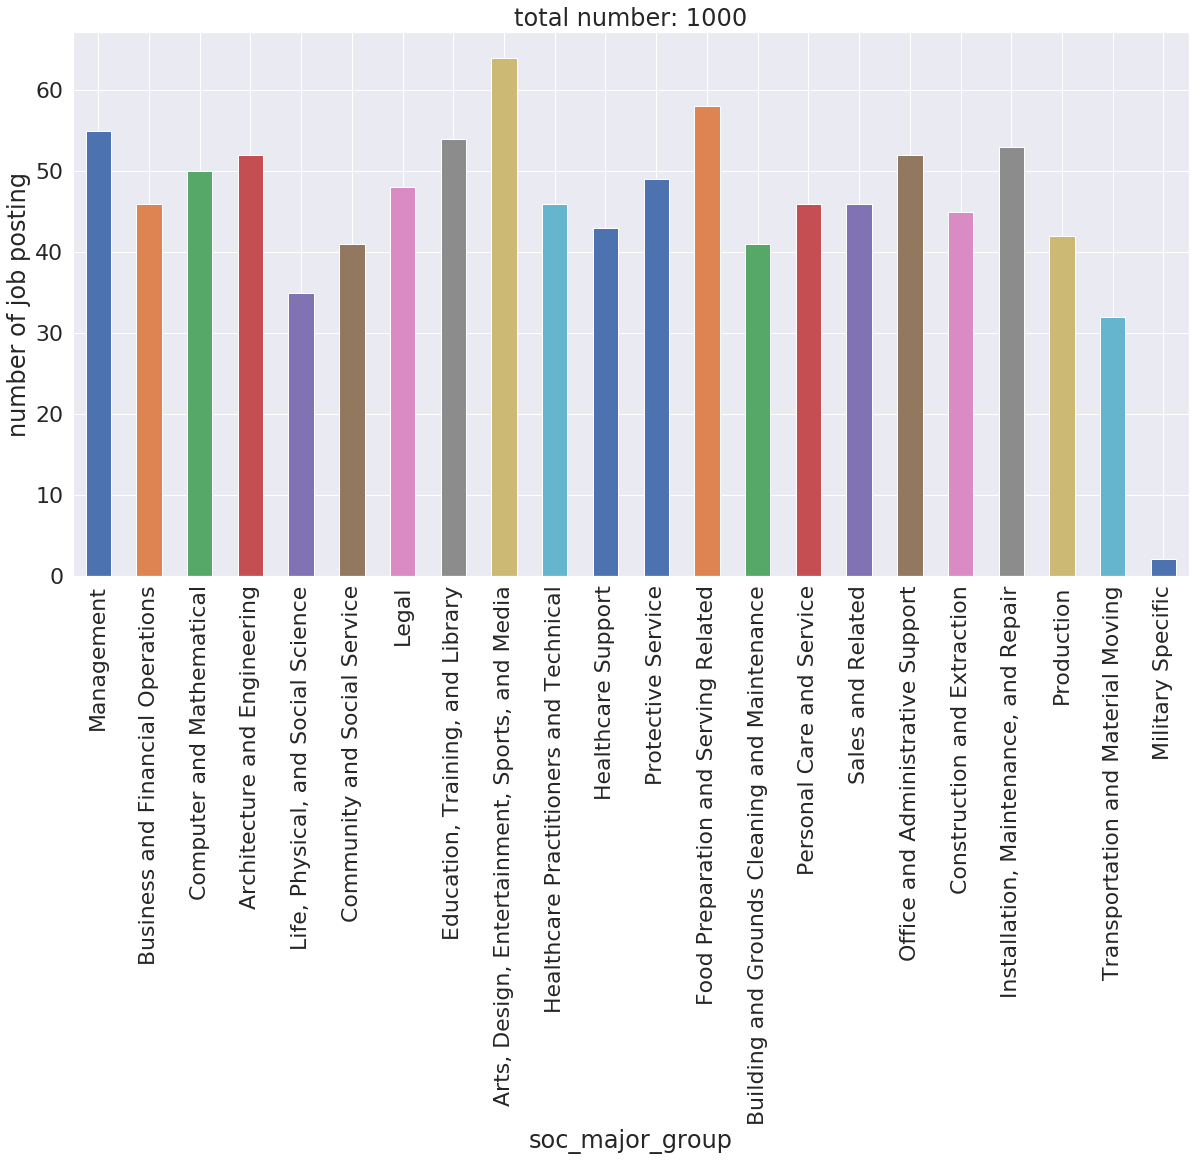

In [143]:
plot_major_group_distribution(sampler)

# Skill Extraction

A common task is extracting competencies from unstructured text. Sometimes this is ontology-based (finding concepts from a known ontology in text), but this is not necessarily true. Skills-ML unites these with a common interface in the SkillExtractor class. The common interface is that every SkillExtractor needs to be able to take in a collection of documents, and yield what we call `CandidateSkill` objects.

## What Is a CandidateSkill?

A CandidateSkill is a possible occurrence of a skill/competency in context in some document. It consists of the following fields:

`skill_name` - The text version of the skill as it appears in the document

`matched_skill_identifier` - A reference to the skill in some ontology. This may be empty, if no ontology was used to search for skills.

`context` - The text surrounding the skill in the document. The goal is for a human labeler to be able to use this to determine whether or not the occurrence represents a true skill. How much context is included is up to the algorithm.

`start_index` - The start index of the skill occurrence within the document string.

`confidence` - The confidence level the algorithm has in this candidate skill being a true occurrence of a skill. This may be empty, if the algorithm has now way of producing a confidence value.

`document_id` - A unique identifier for the source document.

`document_type` - The type of document (examples: Job Posting, Profile, Course Description)

`source_object` - The entire source document.

`skill_extractor_name` - The name of the skill extractor algorithm. Every SkillExtractor subclass defines a name property that is used to give processes downstream context about how their output data was produced.

The idea behind the CandidateSkill object is to serve as a common interface between SkillExtractor objects, automatic evaluation methods, and manual evaluation methods.

- A labeling interface might intake CandidateSkill objects for humans to say yes/no to.
- Another type of labeling interface might involve the export of CandidateSkill objects based on what a human highlighted in the interface when shown the entire document
- Unsupervised evaluation metrics may take in one set of CandidateSkills to produce simple descriptive metrics
- Supervised evaluation metrics may take in one set of CandidateSkills from a SkillExtractor and another set of CandidateSkills from a human labeling interface and use the latter to evaluate the former

We'll talk about some of these use cases in more detail later. But for now, let's start with a simple example that uses NLP rules and isn't tied to an ontology. Let's define a method for extracting skills as 'all noun phrases that end in the word skill or skills'. This is a simple method that realistically won't cover all possible occurrences of skills, but this is a start.

In [152]:
from skills_ml.algorithms.skill_extractors import SkillEndingPatternExtractor
from skills_ml.job_postings.common_schema import JobPostingCollectionSample
job_posting_generator = JobPostingCollectionSample()
# instantiate the skill extractor. This class defaults to only considering lines that
# start with a bullet, which doesn't work for this dataset. So we set this flag to False.
skill_extractor = SkillEndingPatternExtractor(only_bulleted_lines=False)
job_posting = next(iter(job_posting_generator))
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

INFO:root:Yielding candidate skill communication skills in context Excellent client presentation and communication skills as well as strong customer service and organizational skills.
INFO:root:Yielding candidate skill organizational skills in context Excellent client presentation and communication skills as well as strong customer service and organizational skills.
INFO:root:Yielding candidate skill communication skills in context We are proud to be an equal opportunity employer College degree preferred, 2 - 5 years experience in print and / or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client presentation and communication skills as well as strong customer service and organizational skills, The ideal can

skill name: communication skills
context: Excellent client presentation and communication skills as well as strong customer service and organizational skills.

skill name: organizational skills
context: Excellent client presentation and communication skills as well as strong customer service and organizational skills.

skill name: communication skills
context: We are proud to be an equal opportunity employer College degree preferred, 2 - 5 years experience in print and / or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self - motivated, team - oriented, and customer - ce

The results for one job posting are modest. Two distinct skill names, each occurring two different times in the document.  This is a start.

Now let's try another skill extractor: matching with ONET data.

In [153]:
from skills_ml.algorithms.skill_extractors import ExactMatchSkillExtractor
skill_extractor = ExactMatchSkillExtractor(onet.competency_framework)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

INFO:root:Found 32029 entries for lookup
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(34, 38), match='self'> in string The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(582, 586), match='self'> in string We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential cust

skill name: self
context: The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.

skill name: self
context: We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential customers and use online analytics from a sales perspective, Weekly local travel to meet with clients/prospects is required, Minimal non local travel a few times a year is required



Yikes. What is this? As it turns out, ['Self' is a real programming language](https://en.wikipedia.org/wiki/Self_(programming_language)). But it's not applicable here. Simply searching for skill names has its limitations.

To help with this, there is also the SocScopedExactMatchSkillExtractor. This does exact matching, but only for the occupation that the document is tagged with. This, of course, is only applicable if the document has one. And it needs a full CompetencyOntology to work.

In [154]:
from skills_ml.algorithms.skill_extractors import SocScopedExactMatchSkillExtractor
skill_extractor = SocScopedExactMatchSkillExtractor(onet)
for candidate_skill in skill_extractor.candidate_skills(job_posting):
    print('skill name:', candidate_skill.skill_name)
    print('context:', candidate_skill.context)
    print('')

INFO:root:Found 32029 entries for lookup
INFO:root:Found 96 entries for lookup


No results. This is expected: For an occupation that is not related to computer programming, the language 'Self' is likely irrelevant.

Here's a list of all the other skill extractors available.

`FuzzyMatchSkillExtractor` - Similar to the ExactMatchSkillExtractor, but using a configurable edit distance to find skill names that are very close to the targets.

`AbilityEndingPatternExtractor` - Similar to the SkillEndingPatternExtractor, but finding noun phrases that end in 'ability' or 'abilities'.

`SectionExtractSkillExtractor` - Attempts to divide the text into sections with headers, which is a common pattern found in job postings. Return each individual sentence found in sections with certain headers (Skills, Competencies, Qualifications).

### Evaluating Skill Extractors

We want to be able to evaluate skill extractors. We may or may not have labeled skills but do want to be able to generate descriptive metrics either way.

In [155]:
from skills_ml.evaluation.skill_extraction_metrics import TotalOccurrences, TotalVocabularySize, OntologyCompetencyRecall

metrics = [
    TotalOccurrences(),
    TotalVocabularySize(),
    OntologyCompetencyRecall(onet)
]
exact_match_skill_extractor = ExactMatchSkillExtractor(onet.competency_framework) 
for metric in metrics:
    candidate_skills = []
    for job_posting in job_posting_generator:
        candidate_skills += list(exact_match_skill_extractor.candidate_skills(job_posting))
    
    print('metric:', metric.name, 'value:', metric.eval(candidate_skills, 50)) 

INFO:root:Found 32029 entries for lookup
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(34, 38), match='self'> in string The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(582, 586), match='self'> in string We are proud to be an equal opportunity employer College degree preferred, 2-5 years experience in print and/or online advertising sales and be able to show consistent sales results in previous positions, Knowledge of the IT industry is preferred, Track record of creativity in sales approaches and solutions, Track record of successfully meeting and exceeding sales goals in media sales relevant to 1105 Medias line of business, Excellent client  presentation and communication skills as well as strong customer service and organizational skills, The ideal candidate is energetic, self-motivated, team-oriented, and customer-centric, Understanding of how to research potential cust

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management & multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(29, 40), match='automobiles'> in string Perform minor diagnostics on automobiles as required.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(90, 96), match='brakes'> in string Repair vehicles according to manufacturers' specifications including, but not limited to, brakes, suspension, exhaust, drive train, cooling system, tires, alignments, air conditioning/heating, ignition system, and fuel system.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(58, 69), match='automobiles'> in string This position performs minor repairs and lube services to automobiles.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(74, 85), match='automobiles'> in string Responsibilities include: perform oil changes 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(22, 36), match='transportation'> in string Package materials for transportation, including Hazmat Materials IAW PWS requirements.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(79, 90), match='originality'> in string Inspects Oem or FAA form 8130-3 / Certificate of conformance documentation for originality and serial number.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(61, 66), match='skill'> in string The requirements listed are representative of the knowledge, skill, and/or ability required.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(50, 57), match='writing'> in string Essential duties and responsibilities: Reports in writing and orally to AAR DSL management.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(82, 83), match='C'> in string Responding to on-site supply requirements generated by the squadron in support of C-40A organizational maintenance.
INFO:root:Yiel

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(156, 162), match='design'> in string Typical duties/responsibilities may include, but are not limited to, the following: perform various engineering tasks involving such functions as analysis, design, development, test, installation and service, while working from instructions, drawings, proposals, specifications, and other pertinent information.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(183, 195), match='installation'> in string Typical duties/responsibilities may include, but are not limited to, the following: perform various engineering tasks involving such functions as analysis, design, development, test, installation and service, while working from instructions, drawings, proposals, specifications, and other pertinent information.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(149, 163), match='transportation'> in string Overall management of the supply management functions includes plann

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(87, 93), match='trucks'> in string Responsibilities include: make local deliveries 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(704, 716), match='coordination'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(738, 750), match='coordination'

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(24, 30), match='design'> in string 10+ years of industrial design in specialty chemicals preferred other industrial industries will be considered if those industries are in line with APS clients electrical and control design experience in industrial process facilities working
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(183, 189), match='design'> in string 10+ years of industrial design in specialty chemicals preferred other industrial industries will be considered if those industries are in line with APS clients electrical and control design experience in industrial process facilities working
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(131, 142), match='programming'> in string Overview:This is an outstanding opportunity for those with demonstrated experience and knowledge related to the areas of planning, programming, budgeting, and execution -LRB-PPBE-RRB-.
INFO:root:Yielding exact match <_s

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(24, 30), match='trucks'> in string You will switch between trucks as needed and will most likely 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(35, 46), match='automobiles'> in string Perform any other basic repairs to automobiles as assigned by a lead tech or manager/service manager/service writer according to his/her abilities.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(41, 47), match='brakes'> in string This could include but not be limited to brakes, suspension, alignments, parts changing, exhaust, ac/heating, maintenance inspections, and tune-ups.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Manag

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(7, 19), match='coordination'> in string Ensure coordination and cooperation with shared service centers.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(29, 35), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(48, 54), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(136, 154), match='power transformers'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, su

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string application/script writing and development.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(22, 34), match='workstations'> in string Troubleshoot servers, workstations, and networked devices.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(33, 38), match='Linux'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(112, 120), match='iptables'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(127, 133), match='design'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(174, 184), match='mechanical'> in str

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(679, 691), match='coordination'> in string Control panel layouts and interconnection motor load list calculations including - load, voltage drop, conduit fill conceptual design able to read P&ID; electrical specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating power sources construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(713, 725), match='coordination'> in string Control panel layouts and interconnection motor

metric: total_candidate_skills value: 153


INFO:root:Yielding exact match <_sre.SRE_Match object; span=(131, 142), match='programming'> in string Overview:This is an outstanding opportunity for those with demonstrated experience and knowledge related to the areas of planning, programming, budgeting, and execution -LRB-PPBE-RRB-.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(175, 186), match='programming'> in string SUMMARY OF SKILLS and qualifications:St. Michael's is seeking candidates who have a firm understanding of Dod Accounting and Audit Practices; required experience in planning, programming, budgeting, and execution -LRB-Ppbe-RRB-; must have experience with automated tools.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(17, 33), match='Microsoft Office'> in string Proficiency with Microsoft Office -LRB-word, Excel, powerpoint-RRB-.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(34, 38), match='self'> in string The ideal candidate is energetic, self-motivated, team-oriented, and

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(24, 30), match='trucks'> in string You will switch between trucks as needed and will most likely not use the same truck on a permanent basis.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(97, 103), match='levels'> in string All Service truck operators are required to maintain the professional image and customer service levels of AAA.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(28, 38), match='mechanical'> in string This position requires some mechanical aptitude/knowledge.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management & multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding ex

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking -must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(110, 116), match='levels'> in string Continually develops plans, programs, and promotions to increase production and customer service satisfaction levels.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(0, 15), match='Time Management'> in string Time Management and multi-tasking - must be able to perform multiple tasks and use time efficiently.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(79, 90), match='originality'> in string Inspects Oem or FAA form 8130-3 / Certificate of conformance documentation for originality and serial number.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(22, 36), match='transportation'> in string Package materials for transportation, including Hazmat Mater

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(48, 54), match='design'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(136, 154), match='power transformers'> in string ABB is seeking an electrical design engineer to design and analyze parts, components, assemblies, subassemblies and systems relating to power transformers, and the production of associated drawings and instructions.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(156, 162), match='design'> in string Typical duties/responsibilities may include, but are not limited to, the following: perform various engineering tasks involving such functions as analysis, design, development, test, installation and service, while working from instructions, drawings, proposals, s

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(112, 120), match='iptables'> in string Operating System's and software: Linux -LRB-Redhat/centos/fedora, windows, Mac OSX-RRB-; Apache; Sendmail/exim; iptables; Selinux; squid proxy.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunications network and a demonstrated ability to quickly assimilate technical data, methods and procedures;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(19, 26), match='writing'> in string Assist in proposal writing and customer communications;.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(49, 67), match='telecommunications'> in string Technical understanding of the components of the telecommunication

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(174, 184), match='mechanical'> in string Mechanical Design of piping systems, machine design, Duct Tie-point lists valve lists equipment lists conceptual design detail design drawings including plans and isometrics mechanical/piping specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating tie-points construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team participation in project meetings.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(704, 716), match='coordination'> 

INFO:root:Yielding exact match <_sre.SRE_Match object; span=(713, 725), match='coordination'> in string Control panel layouts and interconnection motor load list calculations including - load, voltage drop, conduit fill conceptual design able to read P&ID; electrical specifications construction scopes of work and Specifications Construction Bid Packages Support Development of Project Engineering Bids Support Development of engineering scopes of Work Support Development of total install cost estimates development of scope change orders input to project schedule - development and ongoing client and vendor correspondence client and vendor meetings meeting minutes site work - including as built conditions, locating power sources construction support/oversight Inter-discipline coordination and intra-discipline coordination with project team.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(24, 30), match='design'> in string 10+ years of industrial design in specialty chemicals p

metric: total_vocabulary_size value: 40


INFO:root:Yielding exact match <_sre.SRE_Match object; span=(183, 189), match='design'> in string 10+ years of industrial design in specialty chemicals preferred other industrial industries will be considered if those industries are in line with APS clients electrical and control design experience in industrial process facilities working
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(131, 142), match='programming'> in string Overview:This is an outstanding opportunity for those with demonstrated experience and knowledge related to the areas of planning, programming, budgeting, and execution -LRB-PPBE-RRB-.
INFO:root:Yielding exact match <_sre.SRE_Match object; span=(175, 186), match='programming'> in string SUMMARY OF SKILLS and qualifications:St. Michael's is seeking candidates who have a firm understanding of Dod Accounting and Audit Practices; required experience in planning, programming, budgeting, and execution -LRB-Ppbe-RRB-; must have experience with automated tool

metric: onet_ksat_competency_recall value: 0.001248868213181804


# Embedding

- Labor market data tends to be large in scale, but represented as raw text. Consequently, an important early step for most tasks is to transform texts into a mathematical form that can be used in the downstream tasks.

- In the context of skills and jobs, an embedding model trained on large amount of job posting data is able to map a skill or a job title into a high dimensional space as well as preserving the contextual and semantic relationship. Ideally, a good embedding model will cluster similar skills and jobs.

## Embedding Models

Many word embedding techniques have been developed since the most impactful embedding algorithm word2vec was published in 2013. Currently, Skills-ML includes word2vec, doc2vec and fastext and may include more in the future.

- `Word2VecModel` is able to look up a word vector and infer a sentence/paragraph vector by averaging each word in a sentence/paragraph. It supports online learning. For out-of-vocabulary word handling of sentence/paragraph inference, a random vector will be assigned with the same dimension.
- `Doc2VecModel` is able to look up a word vector and infer a sentence/paragraph vector by gradient descending on the fly, so it is non-deterministic. It does not support online learning. 
- `FastTextModel` is able to look up a word vector and infer a sentence/paragraph vector by averaging each word in a sentence/paragraph. It supports online learning. For out-of-vocabulary word handling of sentence/paragraph inference, it sums all vectors of the unseen word’s char-ngrams. If none of the char-ngrams of the unseen word is present, a random vector will be assigned with the same dimension.

In [17]:
from skills_ml.algorithms.embedding.models import Word2VecModel, FastTextModel

cbow = Word2VecModel(size=200, sg=0, window=7, iter=3)
skip_gram = Word2VecModel(size=200, sg=1, window=7, iter=3)
fasttext = FastTextModel(size=200, window=7, iter=3) 

## Corpora

Next, we need some text corpus to train embedding modelss. `Skills-ML` provides pre-defined classes to convert common schema job listings into a corpus in documnet level suitable for use by machine learning algorithms or specific tasks.

- `Word2VecGensimCorpusCreator`
- `Doc2VecGensimCorpusCreator`


In [18]:
from skills_ml.job_postings.corpora import Word2VecGensimCorpusCreator, Doc2VecGensimCorpusCreator

w2v_corpus_generator = Word2VecGensimCorpusCreator(sampler)

## Preprocessing

Or we can build our own corpus generator by using some preprocessing tools

Function Compostition
- `ProcessingPipeline` will compose processing functions together to become a callable object that takes in the input from the very first processing function and returns the output of the last processing function.
- `IterablePipeline` will compose processing functions together to be passed to different stages(training/          prediction)

In [160]:
from skills_ml.algorithms.preprocessing import IterablePipeline
from skills_ml.algorithms import nlp

document_schema_fields = ['description','experienceRequirements', 'qualifications', 'skills']

pipeline = IterablePipeline(
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.clean_html,
    nlp.clean_str,
    nlp.word_tokenize,
)

corpus_generator = pipeline(sampler)

## Train Embedding

The `EmbeddingTrainer` provides online batch learning for Word2VecModel and FastTextModel. 

In [20]:
from skills_ml.algorithms.embedding.train import EmbeddingTrainer


trainer = EmbeddingTrainer(cbow, skip_gram, fasttext, batch_size=100)
trainer.train(corpus_generator)

INFO:root:Training batch #0 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5213 word types from a corpus of 49808 raw words and 100 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=5 retains 1573 unique words (30% of original 5213, drops 3640)
INFO:gensim.models.word2vec:effective_min_count=5 leaves 43471 word corpus (87% of original 49808, drops 6337)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5213 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 50 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 33289 word corpus (76.6% of prior 43471)
INFO:gensim.models.base_any2vec:estimated required memory for 1573 words and 200 dimensions: 3303300 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.b

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5210 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 98 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 69163 word corpus (154.3% of prior 44833)
INFO:gensim.models.base_any2vec:estimated required memory for 3264 words and 200 dimensions: 6854400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 2013 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51151 raw words (35413 effective words) took 0.0s, 944700 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 2323 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 49081 raw words (34378 effective words) took 0.0s, 932551 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 49081 raw words (34330 effective words) took 0.0s, 935117 effective words

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 48717 raw words (34082 effective words) took 0.0s, 903611 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 48717 raw words (33951 effective words) took 0.0s, 912939 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 48867 raw words (34419 effective words) took 0.0s, 895161 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 48867 raw words (34497 effective words) took 0.0s, 907256 effective words/s
INFO:gensim.models.base_any2vec:training on a 146601 raw words (103343 effective words) took 0.1s, 863583 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 55380 raw words (39407 effective words) took 0.0s, 985206 effective words/s
INFO:gensim.models.base_any2vec:training on a 166140 raw words (118105 effective words) took 0.1s, 946632 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5390 word types from a corpus of 55380 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1749 unique words (24% of original 7139) and increased the count of 1749 pre-existing words (24% of original 7139)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5390 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5354 word types from a corpus of 55033 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1723 unique words (24% of original 7077) and increased the count of 1723 pre-existing words (24% of original 7077)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5354 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 100 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 74192 word corpus (153.3% of prior 48393)
INFO:gensim.models.base_any2vec:estimated required memory for 3446 words and 200 dimensions: 7236600 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3048 vocabulary and 200 features, using sg=1

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1609 unique words (23% of original 6867) and increased the count of 1609 pre-existing words (23% of original 6867)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5258 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68618 word corpus (153.8% of prior 44608)
INFO:gensim.models.base_any2vec:estimated required memory for 3218 words and 200 dimensions: 6757800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3167 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

INFO:gensim.models.word2vec:downsampling leaves estimated 62298 word corpus (152.3% of prior 40905)
INFO:gensim.models.base_any2vec:estimated required memory for 3058 words and 200 dimensions: 6421800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3254 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 47310 raw words (33924 effective words) took 0.2s, 209889 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.

INFO:gensim.models.base_any2vec:training model with 3 workers on 3326 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 50272 raw words (36564 effective words) took 0.2s, 206375 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 50272 raw words (36673 effective words) took 0.2s, 206230 effective words/s
INFO:gensim.models.base_any2vec:worker thread fi

INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51254 raw words (37651 effective words) took 0.2s, 214030 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 51254 raw words (37699 effective words) took 0.2s, 215840 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 51254 raw words (37772 effective words) took 0.2s, 215611 effective words/s
INFO:gensim.models.base_any2vec:training on a 153762 raw words (

INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 50094 raw words (36730 effective words) took 0.2s, 213769 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50094 raw words (36702 effective words) took 0.2s, 210279 effective words/s
INFO:gensim.models.base_any2vec:training on a 150282 raw words (110064 effective words) took 0.5s, 210219 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5046 word types from a corpus of 50094 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.mo

INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 53125 raw words (38755 effective words) took 0.2s, 229864 effective words/s
INFO:gensim.models.base_any2vec:training on a 159375 raw words (116316 effective words) took 0.5s, 226781 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5238 word types from a corpus of 53125 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1666 unique words (24% of original 6904) and increased the count of 1666 pre-existing words (24% of original 6904)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5238 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 71883 word corpus (153.8% of prior 46753)
INFO:gensim.

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5127 word types from a corpus of 54870 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1706 unique words (24% of original 6833) and increased the count of 1706 pre-existing words (24% of original 6833)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5127 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 75241 word corpus (154.0% of prior 48849)
INFO:gensim.models.fasttext:estimated required memory for 3657 words, 29286 buckets and 200 dimensions: 31943764 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 604
INFO:gensim.models.base_any2vec:training m

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5338 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 66558 word corpus (153.0% of prior 43512)
INFO:gensim.models.fasttext:estimated required memory for 3738 words, 29790 buckets and 200 dimensions: 32535264 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 504
INFO:gensim.models.base_any2vec:training model with 3 workers on 3738 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 50146 raw words (36309 effective words) took 0.3s

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 375
INFO:gensim.models.base_any2vec:training model with 3 workers on 3788 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 43859 raw words (31993 effective words) took 0.3s, 113300 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 43859 raw words (

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51446 raw words (37697 effective words) took 0.3s, 130788 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 51446 raw words (37817 effective words) took 0.3s, 129666 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 52161 raw words (38182 effective words) took 0.4s, 96483 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 52161 raw words (38186 effective words) took 0.3s, 145679 effective words/s
INFO:gensim.models.base_any2vec:training on a 156483 raw words (114428 effective words) took 0.9s, 123701 effective words/s
INFO:root:Training batch #18 
INFO:gensim.models.word2vec:collecting all 

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 52532 raw words (38999 effective words) took 0.3s, 137621 effective words/s
INFO:gensim.models.base_any2vec:training on a 157596 raw words (116952 effective words) took 0.9s, 136073 effective words/s
INFO:root:Training batch #19 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5187 word types from a corpus of 50957 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1626 unique words (23% of original 6813) and increased the count of 1626 pre-e

INFO:gensim.models.base_any2vec:training on a 152871 raw words (112370 effective words) took 0.8s, 138601 effective words/s
INFO:root:Training batch #20 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5705 word types from a corpus of 54626 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1739 unique words (23% of original 7444) and increased the count of 1739 pre-existing words (23% of original 7444)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5705 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 72593 word corpus (153.0% of prior 47457)
INFO:gensim.models.base_any2vec:estimated required memory for 3478 words and 200 dimensions: 7303800 bytes
INFO:ge

INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5438 word types from a corpus of 55679 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1727 unique words (24% of original 7165) and increased the count of 1727 pre-existing words (24% of original 7165)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5438 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 90 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 75751 word corpus (154.9% of prior 48889)
INFO:gensim.models.base_any2vec:estimated required memory for 3454 words and 200 dimensions: 7253400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4089 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5382 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68405 word corpus (152.1% of prior 44964)
INFO:gensim.models.base_any2vec:estimated required memory for 3236 words and 200 dimensions: 6795600 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4159 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51740 raw words (37374 effective words) took 0.0s, 913149 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4231 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55154 raw words (40629 effective words) took 0.0s, 1004366 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55154 raw words (40703 effective words) took 0.0s, 1009853 effective wor

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 54791 raw words (40710 effective words) took 0.0s, 1028139 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 54791 raw words (40758 effective words) took 0.0s, 1035611 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mo

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 45753 raw words (33833 effective words) took 0.0s, 912650 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 45753 raw words (33685 effective words) took 0.0s, 907068 effective words/s
INFO:gensim.models.base_any2vec:training on a 137259 raw words (101279 effective words) took 0.1s, 860063 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 47689 raw words (35326 effective words) took 0.0s, 923242 effective words/s
INFO:gensim.models.base_any2vec:training on a 143067 raw words (106037 effective words) took 0.1s, 877527 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5171 word types from a corpus of 47689 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1546 unique words (23% of original 6717) and increased the count of 1546 pre-existing words (23% of original 6717)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5171 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5478 word types from a corpus of 55454 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1731 unique words (24% of original 7209) and increased the count of 1731 pre-existing words (24% of original 7209)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5478 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 74704 word corpus (153.1% of prior 48790)
INFO:gensim.models.base_any2vec:estimated required memory for 3462 words and 200 dimensions: 7270200 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4389 vocabulary and 200 features, using sg=1 

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1709 unique words (23% of original 7357) and increased the count of 1709 pre-existing words (23% of original 7357)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5648 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 70299 word corpus (153.6% of prior 45762)
INFO:gensim.models.base_any2vec:estimated required memory for 3418 words and 200 dimensions: 7177800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4437 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

INFO:gensim.models.word2vec:downsampling leaves estimated 70203 word corpus (153.1% of prior 45858)
INFO:gensim.models.base_any2vec:estimated required memory for 3324 words and 200 dimensions: 6980400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4475 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 52115 raw words (38497 effective words) took 0.2s, 230034 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.

INFO:gensim.models.base_any2vec:training model with 3 workers on 4526 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 57786 raw words (42973 effective words) took 0.2s, 237509 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 57786 raw words (42990 effective words) took 0.2s, 238461 effective words/s
INFO:gensim.models.base_any2vec:worker thread fi

INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51019 raw words (37673 effective words) took 0.2s, 218674 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 51019 raw words (37573 effective words) took 0.2s, 220032 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 51019 raw words (37691 effective words) took 0.2s, 218492 effective words/s
INFO:gensim.models.base_any2vec:training on a 153057 raw words (

INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 46574 raw words (34268 effective words) took 0.2s, 204599 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 46574 raw words (34286 effective words) took 0.2s, 203364 effective words/s
INFO:gensim.models.base_any2vec:training on a 139722 raw words (102899 effective words) took 0.5s, 201840 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5215 word types from a corpus of 46574 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.mo

INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50773 raw words (37011 effective words) took 0.2s, 223250 effective words/s
INFO:gensim.models.base_any2vec:training on a 152319 raw words (111225 effective words) took 0.5s, 220045 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5726 word types from a corpus of 50773 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1644 unique words (22% of original 7370) and increased the count of 1644 pre-existing words (22% of original 7370)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5726 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 66528 word corpus (152.9% of prior 43516)
INFO:gensim.

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5712 word types from a corpus of 58212 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1823 unique words (24% of original 7535) and increased the count of 1823 pre-existing words (24% of original 7535)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5712 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 86 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 78943 word corpus (154.4% of prior 51122)
INFO:gensim.models.fasttext:estimated required memory for 4693 words, 35639 buckets and 200 dimensions: 39437076 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 420
INFO:gensim.models.base_any2vec:training m

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5331 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 64080 word corpus (152.7% of prior 41979)
INFO:gensim.models.fasttext:estimated required memory for 4736 words, 35894 buckets and 200 dimensions: 39740976 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 255
INFO:gensim.models.base_any2vec:training model with 3 workers on 4736 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 48649 raw words (35842 effective words) took 0.3s

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 376
INFO:gensim.models.base_any2vec:training model with 3 workers on 4785 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55873 raw words (41515 effective words) took 0.3s, 131103 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55873 raw words (

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 59286 raw words (43847 effective words) took 0.3s, 139199 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 59286 raw words (43889 effective words) took 0.3s, 138989 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 60251 raw words (44605 effective words) took 0.3s, 134982 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 60251 raw words (44544 effective words) took 0.3s, 133866 effective words/s
INFO:gensim.models.base_any2vec:training on a 180753 raw words (133668 effective words) took 1.0s, 133161 effective words/s
INFO:root:Training batch #39 
INFO:gensim.models.word2vec:collecting all

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 52939 raw words (39348 effective words) took 0.3s, 128185 effective words/s
INFO:gensim.models.base_any2vec:training on a 158817 raw words (118075 effective words) took 0.9s, 128132 effective words/s
INFO:root:Training batch #40 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5675 word types from a corpus of 53802 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1682 unique words (22% of original 7357) and increased the count of 1682 pre-e

INFO:gensim.models.base_any2vec:training on a 161406 raw words (118526 effective words) took 1.0s, 113421 effective words/s
INFO:root:Training batch #41 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5280 word types from a corpus of 51096 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1653 unique words (23% of original 6933) and increased the count of 1653 pre-existing words (23% of original 6933)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5280 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 106 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68650 word corpus (154.0% of prior 44567)
INFO:gensim.models.base_any2vec:estimated required memory for 3306 words and 200 dimensions: 6942600 bytes
INFO:g

INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5186 word types from a corpus of 48689 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1557 unique words (23% of original 6743) and increased the count of 1557 pre-existing words (23% of original 6743)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5186 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 98 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 65216 word corpus (153.7% of prior 42434)
INFO:gensim.models.base_any2vec:estimated required memory for 3114 words and 200 dimensions: 6539400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5027 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5348 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 71039 word corpus (153.0% of prior 46441)
INFO:gensim.models.base_any2vec:estimated required memory for 3336 words and 200 dimensions: 7005600 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5043 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 53052 raw words (39534 effective words) took 0.0s, 949481 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5074 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 46588 raw words (34962 effective words) took 0.0s, 899192 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 46588 raw words (34907 effective words) took 0.0s, 919164 effective words

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55208 raw words (40849 effective words) took 0.0s, 1021955 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55208 raw words (40856 effective words) took 0.0s, 1037074 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mo

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 49096 raw words (36401 effective words) took 0.0s, 909599 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 49096 raw words (36450 effective words) took 0.0s, 898070 effective words/s
INFO:gensim.models.base_any2vec:training on a 147288 raw words (109227 effective words) took 0.1s, 864386 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 53638 raw words (39889 effective words) took 0.0s, 994729 effective words/s
INFO:gensim.models.base_any2vec:training on a 160914 raw words (119772 effective words) took 0.1s, 947820 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5426 word types from a corpus of 53638 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1740 unique words (24% of original 7166) and increased the count of 1740 pre-existing words (24% of original 7166)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5426 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5636 word types from a corpus of 62222 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1846 unique words (24% of original 7482) and increased the count of 1846 pre-existing words (24% of original 7482)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5636 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 85044 word corpus (153.3% of prior 55490)
INFO:gensim.models.base_any2vec:estimated required memory for 3692 words and 200 dimensions: 7753200 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5197 vocabulary and 200 features, using sg=1 

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1551 unique words (23% of original 6670) and increased the count of 1551 pre-existing words (23% of original 6670)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5119 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 64841 word corpus (152.9% of prior 42402)
INFO:gensim.models.base_any2vec:estimated required memory for 3102 words and 200 dimensions: 6514200 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5213 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

## Storage
`Skills-ML` has couple useful storage classes that could benefit both local or cloud. 
- `S3Store`: S3 storage engine
- `FSStore`: File system storage engine
- `ModelStorage`: Serialization model storage. 

In [ ]:
from skills_ml.storage import FSStore, S3Store, ModelStorage

s3 = S3Store(path="s3://open-skills-private/model_cache/embedding/examples")
trainer.save_model(storage=s3)

In [ ]:
print(cbow.model_name)
print(cbow.storage)

## Examples

In [40]:
for c, s in zip(cbow.wv.most_similar(['engineer']), skip_gram.wv.most_similar(['engineer'])):
    print(c, s)

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors
/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


('analyst', 0.7798365354537964) ('developer', 0.6383509039878845)
('developer', 0.7765655517578125) ('chemist', 0.6146482825279236)
('sr', 0.6960220336914062) ('tester', 0.5923943519592285)
('designer', 0.6872661113739014) ('sqq', 0.5717993974685669)
('inc', 0.6587458252906799) ('isso', 0.5697096586227417)
('tester', 0.6468680500984192) ('analyst', 0.5694923400878906)
('architect', 0.610358476638794) ('sr', 0.566695511341095)
('administrator', 0.6010503768920898) ('intern', 0.5646124482154846)
('integrator', 0.5975370407104492) ('scientist', 0.5624051094055176)
('radford', 0.583521842956543) ('counterintelligence', 0.5579032897949219)


In [41]:
for c, s in zip(cbow.wv.most_similar(['python']), skip_gram.wv.most_similar(['python'])):
    print(c, s)

('javascript', 0.9134812355041504) ('ruby', 0.876129150390625)
('scripting', 0.90911465883255) ('scripting', 0.8530923128128052)
('xml', 0.8732477426528931) ('javascript', 0.8138092756271362)
('adobe', 0.8699864149093628) ('matlab', 0.8126481175422668)
('sql', 0.8625409603118896) ('shell', 0.8098346590995789)
('java', 0.8588751554489136) ('jsp', 0.7950626611709595)
('ruby', 0.8399261236190796) ('jenkins', 0.7902500629425049)
('languages', 0.8354889154434204) ('eclipse', 0.7884496450424194)
('programming', 0.8312348127365112) ('weblogic', 0.784496545791626)
('unix', 0.827223539352417) ('xenapp', 0.780957818031311)


In [42]:
for c, s in zip(cbow.wv.most_similar(['cnc']), skip_gram.wv.most_similar(['cnc'])):
    print(c, s)

('machine', 0.6447716951370239) ('tearing', 0.7572804689407349)
('steel', 0.6246368885040283) ('mits', 0.7538847327232361)
('machines', 0.6048142910003662) ('machining', 0.7499876022338867)
('cable', 0.6024507284164429) ('rebuilding', 0.7360354065895081)
('machining', 0.601922869682312) ('grinders', 0.7249530553817749)
('instrumentation', 0.5979673266410828) ('conveyor', 0.720536470413208)
('repairing', 0.5719293355941772) ('millwork', 0.7200809717178345)
('temperature', 0.5670315027236938) ('gauge', 0.7152242660522461)
('devices', 0.566103458404541) ('centrifugal', 0.714060366153717)
('window', 0.5612351894378662) ('overhauling', 0.7123638987541199)


## Evaluation

Although there is an emerging trend towards generating embeddings for structured and unstructured data, there is not yet any systematic suite for measuring the quality of embeddings.
We generally follow one of the few works in embedding evaluation [Concept2vec: Metrics for Evaluating Quality of Embeddings for Ontological Concepts] to create metrics for evaluating embedding against the gold standard ontology dataset. The gold standard ontology is curated by domain experts like O*NET, so a good embedding should replicate the structure of the entities in the gold standard taxonomy. In other words, it is useful to see how an embedding reflects the clustering structure.

One trivial clustering is Major Groups of occupations. A good embedding should cluster the occupations which belong to the same major groups.

- `CategorizationMetric`: The cosine similarity between the embedding of the concept and the mean vector of embeddings of all the entities within that concept cluster. This metric aligns a clustering of entities into different categories, reflecting how well the embedding of a concept cluster performs as the background concept of the entities typed by it. 

- `IntraClusterCohesion`: The sum of squared error of the embedding of the centroid of the concept cluster and the embedding of each entities within that cluster. It measures how near the data points in a cluster are to the cluster centroid.

- `MajorGroupRecall`: For a major group, calculate the cosine similarity against all the occupations and find the top n closest occupations. The recall is defined as the number of true positives from top n closest occupations divided by the total number of occupation within the major group.

- `MajorGroupPrecision`: Similarly to MajorGroupRecall which is called Coherence Score in the paper, start by finding the top n closest occupations. The precision is defined as the number of true positives from top n closest occupations divided by n

In [23]:
from skills_ml.ontologies.onet import Onet

major_group_occupation_des_clustering = onet.major_group_occupation_description_clustering

INFO:root:Manual build specified. Building O*NET CompetencyOntology via direct querying from O*NET site, or local cache.
INFO:root:Processing Content Model Reference
INFO:root:Processing occupation data
INFO:root:Processing Knowledge, Skills, Abilities
INFO:root:Processing tools and technology


In [37]:
from skills_ml.evaluation.embedding_metrics import metrics_for_embedding, CategorizationMetric, IntraClusterCohesion, RecallTopN, PrecisionTopN
from skills_ml.algorithms.preprocessing import ProcessingPipeline

def vectorization(embedding):
    p = ProcessingPipeline(
        nlp.normalize,
        nlp.clean_str,
        nlp.word_tokenize,
        partial(nlp.vectorize, embedding_model=embedding)
    )
    return p

categorization_metric = CategorizationMetric(major_group_occupation_des_clustering)
intra_cohesion = IntraClusterCohesion(major_group_occupation_des_clustering)
recall_top = RecallTopN(major_group_occupation_des_clustering, topn=10)
precision_top = PrecisionTopN(major_group_occupation_des_clustering, topn=10)

In [33]:
categorization_metric.eval(vectorization(fasttext))

{'Business and Financial Operations': 0.3631807217535328,
 'Education, Training, and Library': 0.43505167417120894,
 'Personal Care and Service': 0.5737644745502124,
 'Installation, Maintenance, and Repair': 0.20144112793945923,
 'Food Preparation and Serving Related': 0.2618634269574167,
 'Computer and Mathematical': 0.2810471740199748,
 'Arts, Design, Entertainment, Sports, and Media': 0.4675303760216256,
 'Architecture and Engineering': 0.34352786324260254,
 'Building and Grounds Cleaning and Maintenance': 0.3739563900447046,
 'Construction and Extraction': 0.5273951111254735,
 'Production': 0.7776856969324343,
 'Management': 0.6506827008348048,
 'Farming, Fishing, and Forestry': 0.5027744132303372,
 'Life, Physical, and Social Science': 0.5021111283362193,
 'Healthcare Practitioners and Technical': 0.40399815596589417,
 'Healthcare Support': 0.9287249178783993,
 'Legal': 0.5246977517878302,
 'Transportation and Material Moving': 0.3614192693055597,
 'Protective Service': 0.83687172

In [39]:
evaluate([cbow, skip_gram, fasttext], vectorization, categorization_metric)

,word2vec_8f6d03561111bac0f017b5fffdae60c8,word2vec_ca5188f61975dff05d6e20f1bd2c7f4d,fasttext_48ea4f986ef88ff1f657ddfecd8ef974
algorithm,Continuous Bag of Words,Skip-Gram,Continuous Bag of Words
max,0.90666,0.632917,0.928725
max_cluster,Military Specific,Production,Healthcare Support
mean,0.496794,0.354966,0.500857
min,0.145961,0.182915,0.201441
min_cluster,"Installation, Maintenance, and Repair",Building and Grounds Cleaning and Maintenance,"Installation, Maintenance, and Repair"
std,0.210648,0.120869,0.199344
type,word2vec,word2vec,fasttext
variance,0.0443724,0.0146094,0.039738
window,7,7,7


# Occupation Classification

A common issue with job posting data is incomplete, incorrect, and inconsistent occupation classification. The majority of job postings in the US are using the O*NET SOC classification system, but many are either missing or poorly classified. This can be improved by using machine learning.

## SOC Codes
Most of the job posting data collected are aligned with the O*NET SOC system. The occupations in the SOC are classified at four levels of aggregation: major group, minor group, broad occupation, and detailed occupation. Each lower level of detail identifies a more specific group of occupations. Each item in the SOC is designated by a six-digit code. The first two digits represent the major group, the third digit represents the minor group, the fourth and fifth digits represent the broad occupation, and the sixth digit represents the detailed occupation.
- Major group codes end with 0000 (e.g., 29-0000 Healthcare Practitioners and Technical
Occupations —the exceptions are minor groups 15-1200 Computer Occupations, 31- 1100 Home Health and Personal Care Aides; and Nursing Assistants, Orderlies, and Psychiatric Aides, and 51-5100 Printing Workers, which end with 00). 
- Minor groups generally end with 000 (e.g., 29-1000 Health Diagnosing or Treating Practitioners).
- Broad occupations end with 0 (e.g., 29-1020 Dentists).
- Detailed occupations end with a number other than 0 (e.g., 29-1022 Oral and Maxillofacial Surgeons).


## Target Variable

- `FullSOC`
- `SOCMajorGroup`

In [76]:
from skills_ml.algorithms.occupation_classifiers import FullSOC, SOCMajorGroup

full_soc = FullSOC(onet_cache=onet)

## Design Matrix

The classification task consists of inferring a SOC code from a job posting and is accomplished through several stages: preprocessing, filtering, training and testing. `DesignMatrix` helps users accomplish this task.

    

In [112]:
import random
from itertools import islice
from skills_ml.algorithms.occupation_classifiers import DesignMatrix

            
sample = JobSampler(job_posting_generator=jobpostings_filtered, k=5000, major_group=True, weights=weights)
    
dataset = itershuffle(sample)
train = islice(dataset, 0, 4000)
test = islice(dataset, 4000)
            
            
pipe_x = IterablePipeline(
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.clean_str,
    nlp.word_tokenize,
    partial(nlp.vectorize, embedding_model=fasttext)
)

pipe_y = IterablePipeline(
    full_soc.transformer
)        
    

matrix = DesignMatrix(
    train, 
    full_soc,
    pipe_x,
    pipe_y,
)


## OccupationClassifierTrainer
`OccupationClassifierTrainer` trains classifiers with cross validation and picks the best classifier with a grid search based on the metric. It takes in a dictionary for the grid search.

In [104]:
from skills_ml.algorithms.occupation_classifiers.train import OccupationClassifierTrainer

grid_config = {
                 'sklearn.ensemble.ExtraTreesClassifier': {
                     'n_estimators': [50, 100],
                     'criterion': ['entropy', 'gini'],
                     'max_depth': [20],
                     'max_features': ['log2'],
                     'min_samples_split': [10]
                      },
                 'sklearn.neural_network.MLPClassifier': {
                    'hidden_layer_sizes': [100, 500],
                     'activation': ['logistic', 'relu'],
                     'solver': ['adam']
                     },
                 }

cls_trainer = OccupationClassifierTrainer(
    matrix=matrix,
    k_folds=3,
    grid_config=grid_config,
    storage=S3Store('s3://open-skills-private/model_cache/soc_classifiers/examples'),
    n_jobs=4)

In [105]:
cls_trainer.train(save=False)

INFO:root:Start training 2018-11-07T10:00:55.791017
INFO:root:Building matrix
INFO:root:total jobpostings: 4000
INFO:root:filtered jobpostings: 4000
INFO:root:dropped jobposting: 0.0
INFO:root:training ExtraTreesClassifier
INFO:root:Creating model hash from unique data {'className': 'ExtraTreesClassifier', 'parameters': {'n_estimators': [50, 100], 'criterion': ['entropy', 'gini'], 'max_depth': [20], 'max_features': ['log2'], 'min_samples_split': [10]}, 'project_path': 's3://open-skills-private/model_cache/soc_classifiers/examples', 'training_metadata': {'pipe_X': ['partial(func, *args, **keywords) - new function with partial application\n    of the given arguments and keywords.\n', '\n    Args:\n        text: A unicode string\n    Returns:\n        str: lowercased, sans punctuation, non-English letters\n    ', '\n    Args:\n        text (str): a unicode string\n    Returns:\n        list: tokenized words\n    ', 'partial(func, *args, **keywords) - new function with partial application\

In [106]:
cls_trainer.best_estimators

[<ProxyObjectWithStorage at 0x7f1c16184ca8 for GridSearchCV at 0x7f1c1a441320>,
 <ProxyObjectWithStorage at 0x7f1c19285fc0 for GridSearchCV at 0x7f1c1a7e3940>]

## Evaluation

Accuracy, recall, precision and f1 are the metrics taken into consideration. Since it is a multi-class classification problem, an overall performance is evaluated by looking at the micro-average and macro-average for the metrics. A macro-average will compute the metric independently for each class and then take the average, whereas a micro-average will aggregate the contributions of all classes and then computes the average. In other words, a macro-average is treating all classes equally. 

In [108]:
from skills_ml.algorithms.occupation_classifiers.test import OccupationClassifierTester
from skills_ml.evaluation.occ_cls_evaluator import OnetOccupationClassificationEvaluator
from skills_ml.algorithms.occupation_classifiers.classifiers import CombinedClassifier
from skills_ml.algorithms.embedding.train import Reiterable

steps = [
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.normalize,
    nlp.clean_str,
    nlp.word_tokenize,
]

evaluators = []
for cls in cls_trainer.best_estimators:
    tester = OccupationClassifierTester(
        test_data_generator=list(test), 
        preprocessing=steps, 
        classifier=CombinedClassifier(fasttext, cls)
    )
    evaluators.append(OnetOccupationClassificationEvaluator(tester))


In [ ]:
for e, c in zip(evaluators, cls_trainer.best_estimators):
    print(c.best_estimator_)
    print('accuracy: ', e.accuracy)
    print('precision: ', e.precision)
    print('f1: ', e.f1)
    print('major group: ', e.accuracy_major_group)
    print('macro precision: ', e.macro_precision)
    print('micro precision: ', e.micro_precision)
    print('recall: ', e.recall)
    print('macro recall: ', e.macro_recall)
    print('micro recall: ', e.micro_recall)
    print('macro f1: ', e.macro_f1)
    print('micro f1: ', e.micro_f1)
    print('\n')